## Forward Model Using Separable DeepONet

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


In [2]:
class config:
    def __init__(self):
        #The File paths
        self.train_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/train_samples'
        self.test_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/test'
        #self.test_num = sum(1 for f in folder.iterdir() if f.is_file())
        #print(f'The number of files in test data is: {self.test_num}') 
        #self.submission_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/sample_submission.csv'
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/fwi_model.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/checkpoint_fwi'
        self.dset1 = ["FlatVel_A","FlatVel_B", "Style_A", "Style_B","CurveVel_A","CurveVel_B"] #Dataset storage names used for training
        self.dset2 = ["FlatFault_A", "FlatFault_B", "CurveFault_A", "CurveFault_B"]

        #Trunk Net parameter
        self.base_channel = 32
        self.hidden_dim = 64
        self.layers = 5
        
        #Branch Net Parameter
        self.n_unets = 2
        self.out = 50
        #Optimizer
        self.lr = 0.0006
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 150
        self.batch_size = 50

        #Learning rate scheduler
        self.step_size = 50  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config()

### 1.1 Preparing the Data

In [3]:

def prepare_data(cfg):
    #First we extract the velocity and seismic data's for training and testing
    vel_data = []; seismic_data = [] #; test_data = []

    #Extracting and concatenating the training data
    for domain in cfg.dset1: 
        model_path = Path(cfg.train_path) / domain / "model"
        data_path = Path(cfg.train_path) / domain / "data"
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("*.npy"))]
    
    for domain in cfg.dset2: 
        model_path = Path(cfg.train_path) / domain 
        data_path = Path(cfg.train_path) / domain
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("vel*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("seis*.npy"))]

    
    # Concatenate all at once
    sample_points = sum(v.shape[0] for v in vel_data) #To ensure we have the required number of data
    vel_data = np.concatenate(vel_data, axis=0)
    #Normalizing the velocity data
    #vel_data = (vel_data - vel_data.mean())/(vel_data.std() + 1e-8)
    seismic_data = np.concatenate(seismic_data, axis=0)
    #Normalizing the seismic data
    #seismic_data = (seismic_data - seismic_data.mean())/(seismic_data.std() + 1e-8)
    assert ( vel_data.shape[0] == sample_points and seismic_data.shape[0] == sample_points
           ), f"Expected sample size {sample_points} but got {vel_data.shape[0]} and {seismic_data.shape[0]}"
    print(f"Total data --> Seismic: {seismic_data.shape}, Velocity: {vel_data.shape}")

    #Next we split the downsampled dataset into training, testing and validation
    dataset = TensorDataset(torch.from_numpy(vel_data).float(), torch.from_numpy(seismic_data).float())

    branch_train_set, val_set, test_set = random_split(dataset, [sample_points - 200, 100, 100])

    print(f"After Split, Train samples: {len(branch_train_set)}, test samples: {len(test_set)}, validation_samples: {len(test_set)}")
    

    #DataLoader
    train_loader = DataLoader(branch_train_set, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_set, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader 


In [4]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader= prepare_data(self.cfg)
        print('DataLoaded Successfully!!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader
    
    def predict_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
data_module.setup()

Total data --> Seismic: (10000, 5, 1000, 70), Velocity: (10000, 1, 70, 70)
After Split, Train samples: 9800, test samples: 100, validation_samples: 100
DataLoaded Successfully!!


### Visualizing the dataset

In [5]:
batch = next(iter(data_module.predict_dataloader()))
vel, seis = batch
print("Velocity batch shape:", vel.shape)
print("Seismic batch shape:", seis.shape)

print(torch.max(seis))

Velocity batch shape: torch.Size([50, 1, 70, 70])
Seismic batch shape: torch.Size([50, 5, 1000, 70])
tensor(52.3446)


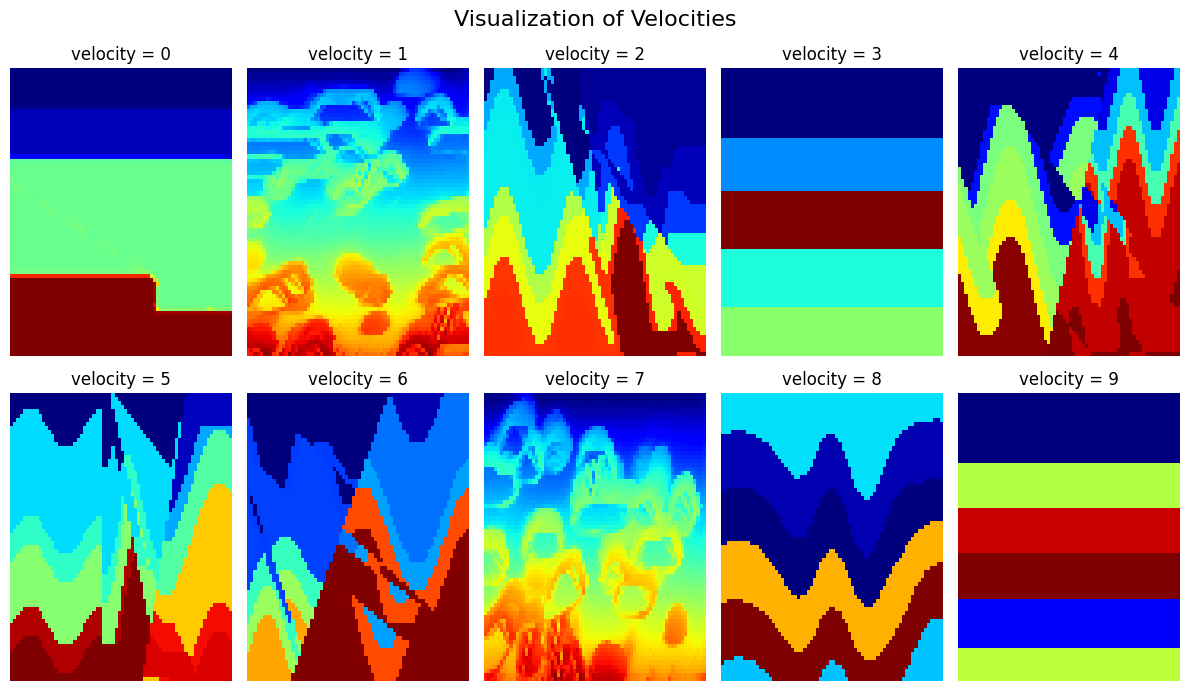

In [6]:
plt.figure(figsize = (12,7))
plt.suptitle("Visualization of Velocities", fontsize=16)
vel_new = vel.squeeze(1)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f"velocity = {i}")
    plt.imshow(vel_new[i], cmap='jet', extent=[0, 70, 70, 0], aspect='auto')
    plt.axis("off")
plt.tight_layout()
plt.show()

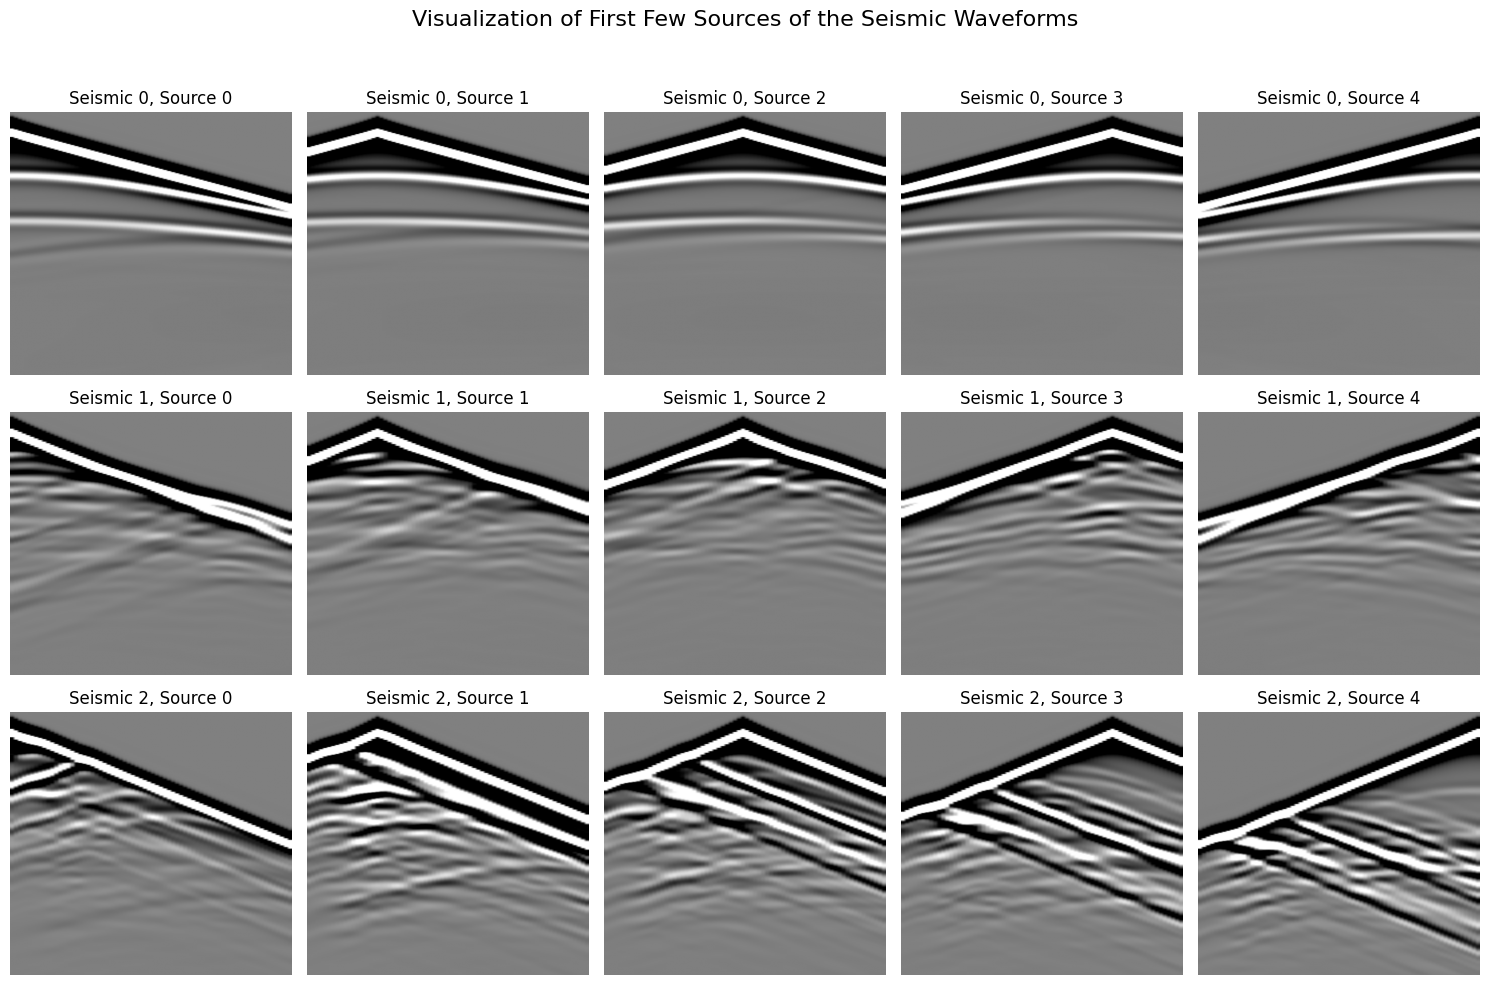

In [7]:
plt.figure(figsize=(15, 10))  # Adjust width for 5 columns
plt.suptitle("Visualization of First Few Sources of the Seismic Waveforms", fontsize=16)

num_samples = 3
num_sources = 5

for i in range(num_samples):       # Rows: each seismic sample
    for j in range(num_sources):   # Columns: each source
        plt.subplot(num_samples, num_sources, num_sources * i + j + 1)
        plt.imshow(seis[i, j, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
        plt.title(f"Seismic {i}, Source {j}")
        plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Building the Seismic Separable U-DeepONet

### The UNet

In [8]:
#We will be defining the convolutional block
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        """
        conv --> batchnorm --> LeakyReLU
        """
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True)
        )
    
    def forward(self,x):
        return self.block(x)

In [9]:
#Now we define the downsampling and upsampling layer in the UNet.
#the Downsampling here are done using appropriate strides and padding
class up_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2),
            nn.LeakyReLU(inplace = True)
        )
        

    def forward(self, x1, x2): #x2 is the skip connection from the encoder
        x1 = self.up(x1)
        
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        
        return x

#Finally the output convolution layer
class out_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x1, x2):
        x1 = self.conv1(x1) #This reduces the channels coming from the decoder from 2f --> f
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        return self.conv2(x)  # keeps spatial dims intact

In [10]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.base_channel = cfg.base_channel
        #The Encoder block (There are 5 blocks in the encoder block)
        self.encoder_block = nn.ModuleList()
        for i in range(5):
            if i == 2 or i == 4:
                self.encoder_block.append(conv_block(self.base_channel, self.base_channel, stride = 1))
            else:
                self.encoder_block.append(conv_block(self.base_channel, self.base_channel, stride = 2))

        #There is no bottleneck or connection in this UNet
    
        #The decoder block (There are 3 blocks here)
        self.decoder_block = nn.ModuleList()
        for i in range(3):
            if i == 0:
                self.decoder_block.append(up_layer(self.base_channel, self.base_channel))
            else:
                self.decoder_block.append(up_layer(2*self.base_channel, self.base_channel))
    
        #The final output convolution
        self.final_conv = out_conv(2*self.base_channel, self.base_channel)
        self.activation = nn.LeakyReLU(inplace = True)

    def forward(self, x):
        res = []
        res.append(x)
    
        for i, down in enumerate(self.encoder_block):
            x = down(x)
            if i < 3:
                res.append(x)
    
        for i, up in enumerate(self.decoder_block):
            x2 = res.pop()
            x = up(x, x2)
        x3 = res.pop()
        x = self.final_conv(x,x3)
        return x #self.activation(x)

### The Branch Net

In the Branch Net:
* The U-Net will extract spatial/geological features common to all sources.
* The source-specific FC layers allow specialization (e.g., certain patterns may matter more for source 0 vs source 4).
* A source encoding is added to let the neural network explicitly know which source it is dealing with, beyond just having a separate head for each source. This can allow the network to adapt more flexibly to each source.

In [11]:
#A Multi source branch net with source encoding
class branch_net(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.activation = nn.ReLU()
        self.base_channel = cfg.base_channel    
        self.pad = nn.ConstantPad2d((4,4,4,4),0)
        self.lift = nn.Conv2d(in_channels=1, out_channels=self.base_channel, kernel_size=1)
        self.unet = UNet(cfg)
        self.conv_blocks = nn.ModuleList([conv_block(self.base_channel, self.base_channel, stride=2) for _ in range(3)])
        self.flatten = nn.Flatten()
        self.fc1 = nn.ModuleList([nn.Linear(self.base_channel * 64 + 5, self.cfg.hidden_dim) for _ in range(5)]) #5 sources
        self.fc2 = nn.ModuleList([nn.Linear(self.cfg.hidden_dim, self.cfg.hidden_dim)  for _ in range(5)])
        self.fc3 = nn.ModuleList([nn.Linear(self.cfg.hidden_dim, self.cfg.out) for _ in range(5)])

    def forward(self, x):
        outs = []
        assert x.shape[1:] == (1,70,70), f"Unexpected input shape: {x.shape}"
        x = self.pad(x) #(batch, 1,70,70) --> (batch, 1, 78, 78)
        x = self.lift(x) #(batch, 1, 78, 78) --> (batch, f, 78, 78)
        x_feature = self.unet(x) #(batch, f, 78, 78) --> (batch, f, 78, 78)
        for conv in self.conv_blocks:
            x_feature = conv(x_feature)   #(batch, f, 78, 78) --> (batch, f, 8, 8)
        x_feature = self.flatten(x_feature) #(batch, f, 8, 8) --> (batch, f * 64)
        for i in range(5):
            #A one-hot encoding for the current source
            source_code = torch.zeros((x_feature.size(0), 5), device=x_feature.device) # Creates a (batch,5) zero vector
            source_code[:, i] = 1.0  # setting the i-th position to 1 for all batch
            # Concatenating source encoding to feature vector
            x_with_code = torch.cat([x_feature, source_code], dim=1) # (batch, f*64) --> (batch, f*64 + 5)
            #Two fully connected layer for source specific informations
            xi = self.activation(self.fc1[i](x_with_code)) #(batch, f * 64 + 5) --> (batch, 128)
            xi = self.activation(self.fc2[i](xi)) #(batch, 128) --> (batch, 128)
            xi = self.fc3[i](xi)  #(batch, 128) --> (batch, out_dim)
            outs.append(xi)
        output = torch.stack(outs, dim=1) #(batch,5,out_dim)
        return output

### Trunk Net

In [12]:
#cfg.x_grid = torch.linspace(0,690, 70).view(-1,1)
## Normalize x_grid (critical!)
#

In [13]:
#The Trunk net 
#Preparing data
cfg.t_grid = torch.linspace(0,1,1000).view(-1,1)
cfg.x_grid = torch.linspace(0,690, 70).view(-1,1)
#Scaling
x_mean, x_std = cfg.x_grid.mean(), cfg.x_grid.std()
cfg.x_grid = (cfg.x_grid - x_mean) / (x_std + 1e-6)


#A separable DeepONet
class trunk_net(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.ReLU()
        self.out = cfg.out
        self.hidden_dim = cfg.hidden_dim
        self.layers = cfg.layers

        self.linears_x = nn.ModuleList()
        self.linears_t = nn.ModuleList()

        self.linears_x.append(nn.Linear(1, self.hidden_dim))
        self.linears_t.append(nn.Linear(1, self.hidden_dim))
        for _ in range(self.layers - 2):
            self.linears_x.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.linears_t.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears_x.append(nn.Linear(self.hidden_dim, self.out))
        self.linears_t.append(nn.Linear(self.hidden_dim, self.out))

    def forward(self, x, t):
        for linear in self.linears_x[:-1]:
            x = self.activation(linear(x))
        x = self.linears_x[-1](x)  # (70, out)
        for linear in self.linears_t[:-1]:
            t = self.activation(linear(t))
        t = self.linears_t[-1](t)  # (1000, out)
        merger = torch.einsum("td,xd->txd", t, x)  # (1000, 70, out)
        return merger  # (1000, 70, out)

### Putting All Together

In [14]:
class seismic_DeepONet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = branch_net(cfg)
        self.trunk = trunk_net(cfg)
        self.cfg = cfg

    def forward(self,v):
        """
        v: shape (batch, 1,70, 70)
        x: shape (70,1)
        t: shape (1000,1)

        output: (batch, 5, 1000, 70)
        """
        t = self.cfg.t_grid.to(v.device)
        x = self.cfg.x_grid.to(v.device)

        B = x.shape[0]
        T = t.shape[0]
        #The branch net: (batch, 1,70,70) --> (batch, 5,50)
        B_out = self.branch(v) 

        #The Trunk net: (1000,1), (70,1) --> (1000,70,50)
        T_out = self.trunk(x,t) 

        #Final output:
        output = torch.einsum("abe,cde->abcd", B_out, T_out)     #(batch,5,1000,70)

        return output

In [15]:
def loss_function(y_true,y_hat, beta = 0.5):
   lp_norm = lambda x: torch.norm(x, p=2)
   assert y_hat.shape == y_true.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y_true.shape}"
   #The value loss
   val_loss = lp_norm(y_true - y_hat) / (lp_norm(y_true)+1e-6) #To avoid division by zero)
   # Derivative loss along x-direction (width = dim 3) using central differencing scheme
   dy_true = (y_true[:, :, :, 2:] - y_true[:, :, :, :-2])/2
   dy_hat = (y_hat[:, :, :, 2:] - y_hat[:, :, :, :-2])/2
   deriv_loss = lp_norm(dy_hat - dy_true) / (lp_norm(dy_true) + 1e-6)
   return val_loss + beta * deriv_loss


y = torch.randn(20,5,1000,70); y_h = torch.randn(20,5,1000,70)
lp = loss_function(y,y_h, beta = 0.5)
lp

tensor(2.1215)

## Training

In [16]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = seismic_DeepONet(cfg)
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def loss_function(self,y_true,y_hat, beta = 0.5):
        lp_norm = lambda x: torch.norm(x, p=2)
        assert y_hat.shape == y_true.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y_true.shape}"
        #The value loss
        val_loss = lp_norm(y_true - y_hat) / (lp_norm(y_true)+1e-6) #To avoid division by zero)

        # Derivative loss along x-direction (width = dim 3) using central differencing scheme
        dy_true = (y_true[:, :, :, 2:] - y_true[:, :, :, :-2])/2
        dy_hat = (y_hat[:, :, :, 2:] - y_hat[:, :, :, :-2])/2
        deriv_loss = lp_norm(dy_hat - dy_true) / (lp_norm(dy_true) + 1e-6)

    
        return val_loss + beta * deriv_loss

    def Loss(self,y_true,y_hat):
        return F.mse_loss(y_true,y_hat)
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.loss_function(y,y_hat, beta = 0.5)
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]
    

    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.loss_function(y,y_hat, beta = 0.5)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        seis_hat = torch.cat(predictions,dim =0); seis_true = torch.cat(targets,dim =0)
        print(f"Average Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, seis_hat, seis_true        

In [17]:
#Training the model
model = PlModel(cfg)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

PlModel(
  (model): seismic_DeepONet(
    (branch): branch_net(
      (activation): ReLU()
      (pad): ConstantPad2d(padding=(4, 4, 4, 4), value=0)
      (lift): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      (unet): UNet(
        (encoder_block): ModuleList(
          (0-1): 2 x conv_block(
            (block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
            )
          )
          (2): conv_block(
            (block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
            )
          )
          (3): conv_block(
            (block): Sequential(
              (0): Conv2d(32,

In [18]:
batch = next(iter(data_module.predict_dataloader()))
vel, seis = batch
pred = model(vel)
print(pred.mean().item(), pred.std().item())

-0.00022945307136978954 0.002273860853165388


In [19]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'seis-deeponet-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 5,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Total data --> Seismic: (10000, 5, 1000, 70), Velocity: (10000, 1, 70, 70)
After Split, Train samples: 9800, test samples: 100, validation_samples: 100


c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\FWI\dataset\checkpoint_fwi exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | seismic_DeepONet | 919 K  | train
---------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode


DataLoaded Successfully!!
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 149: 100%|██████████| 196/196 [00:10<00:00, 18.40it/s, v_num=13, train_loss_step=0.635, val_loss_step=0.625, val_loss_epoch=0.620, train_loss_epoch=0.610]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 196/196 [00:10<00:00, 18.35it/s, v_num=13, train_loss_step=0.635, val_loss_step=0.625, val_loss_epoch=0.620, train_loss_epoch=0.610]


## Evaluation

In [33]:
#First load best model with validation in checkpoint
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("seis-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.predict_dataloader()
#predictions = trainer.predict(model, dataloaders=pred_loader)

In [34]:
avgloss, preds, exact = model.evaluate_on_test_set(pred_loader)

Average Loss on exact test set: 0.5955


In [35]:
exact.shape

torch.Size([100, 5, 1000, 70])

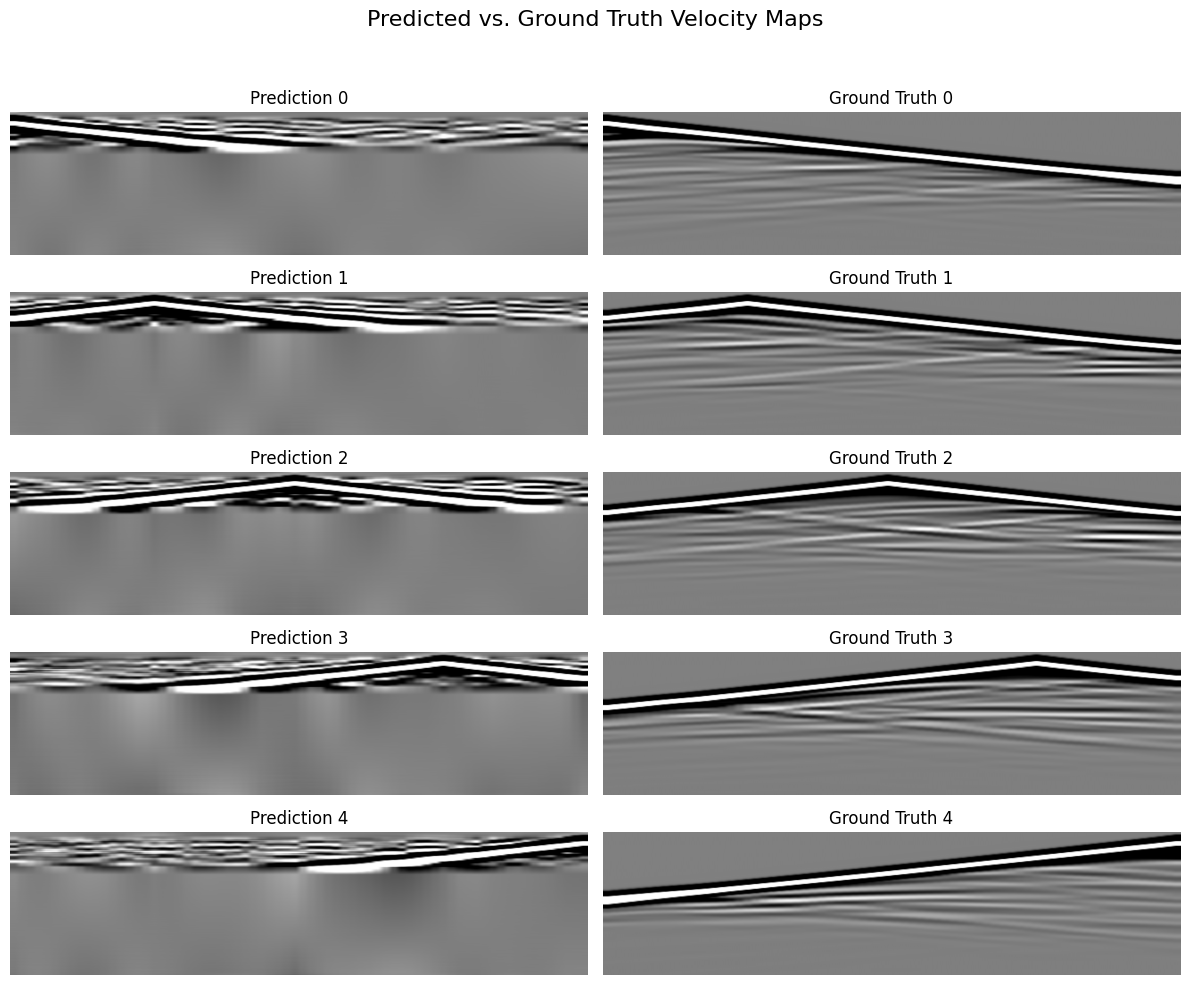

In [37]:
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth Velocity Maps", fontsize=16)
n = 0
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[n, i, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[n, i, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


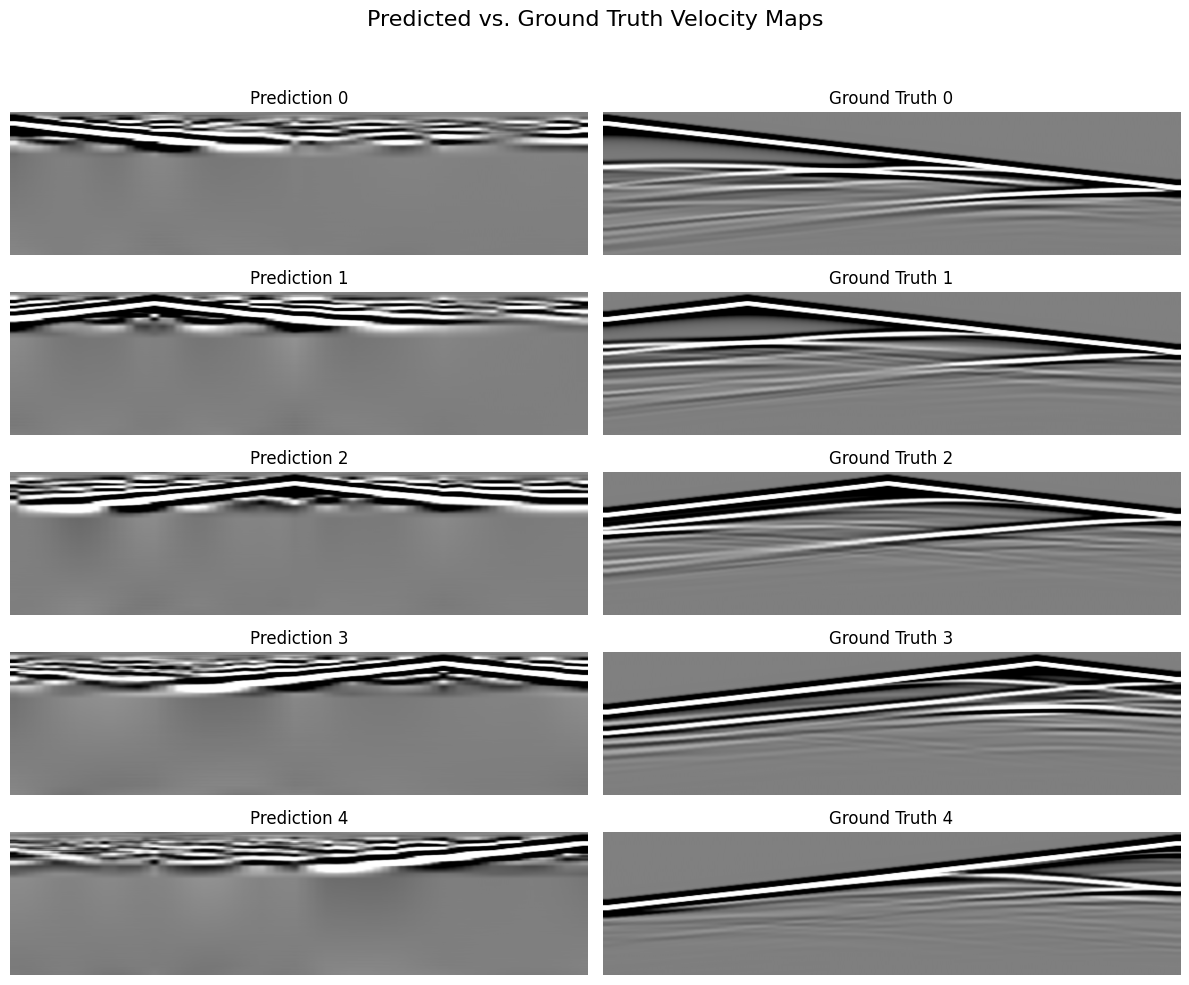

In [24]:

plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth Velocity Maps", fontsize=16)
n = 10
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[n, i, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[n, i, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
